# **Face detection with OpenCV**
![대체 텍스트](https://pyimagesearch.com/wp-content/uploads/2018/02/deep_learning_face_detection_opencv.gif)



1.   OpenCV’s deep learning face detector is based on **the Single Shot Detector (SSD)** framework with a **ResNet** base network. 
2.   The network is defined and trained using the [Caffe Deep Learning framework](https://caffe.berkeleyvision.org/)





# Data Load of image, video and model


Download the pre-trained face detection model, consisting of two files:

- The network definition (face_deploy.prototxt)
- The learned weights (res10_300x300_ssd_iter_140000.caffemodel) 






In [1]:
%%shell
mkdir faceDection; cd faceDection
mkdir model; cd model
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Model/face_deploy.prototxt 
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Model/face_deploy.caffemodel

cd ..; mkdir images; cd images
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Images/face_01.jpeg 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   162  100   162    0     0    885      0 --:--:-- --:--:-- --:--:--   885
100 28092  100 28092    0     0  74121      0 --:--:-- --:--:-- --:--:-- 74121
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0    803      0 --:--:-- --:--:-- --:--:--   800
100 10.1M  100 10.1M    0     0  9129k      0  0:00:01  0:00:01 --:--:-- 9129k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   155  100   155    0     0    654      0 --:--:-- --:--:-- --:--:--   651
100  253k  100  253k    0     0   540k      0 --:--:-- --:--:-- --:--:--  540k


In [2]:
# import the necessary packages
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os

In [3]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./faceDection/")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "model")
# Directory of images/video to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

prototxtPath = os.path.sep.join([MODEL_DIR, "face_deploy.prototxt"])  
weightsPath = os.path.sep.join([MODEL_DIR, "face_deploy.caffemodel"]) 
faceNet = cv2.dnn.readNetFromCaffe(prototxtPath, weightsPath)

In [4]:
conf_threshold = 0.25

# **1**.Detection model demo by picture

In [5]:
# load the input image
image_list = []
detections_list = [] 
for file in os.listdir(IMAGE_DIR):
  file_path = os.path.join(IMAGE_DIR, file)
  if(os.path.isfile(file_path)): 
    image = cv2.imread(file_path)
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0)) 
    faceNet.setInput(blob)
    detections = faceNet.forward()
    image_list.append(image)
    detections_list.append(detections)

In [6]:
# loop over the detections
for i, detections in enumerate(detections_list):
	for j in range(0, detections.shape[2]):
		(high, width) = image_list[i].shape[:2]
		confidence = detections[0, 0, j, 2]

		if confidence > conf_threshold:
			box = detections[0, 0, j, 3:7] * np.array([width, high, width, high])        
			(startX, startY, endX, endY) = box.astype("int")
	
			text = "{:.2f}%".format(confidence * 100)
			y = startY - 10 if startY - 10 > 10 else startY + 10
			cv2.rectangle(image_list[i], (startX, startY), (endX, endY), (0, 0, 255), 2)
			cv2.putText(image_list[i], text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

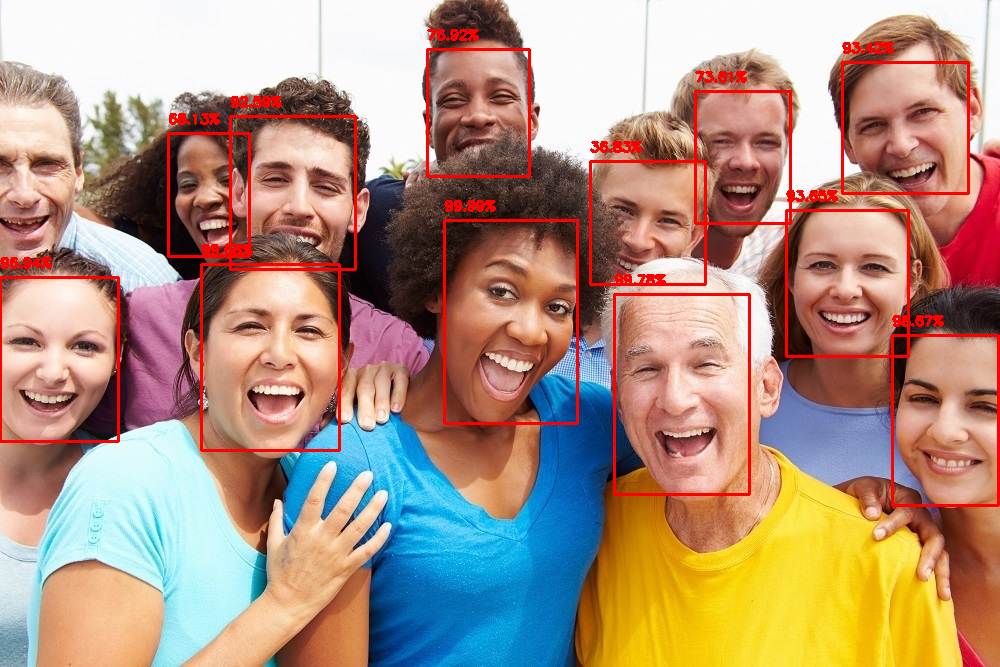

In [7]:
# show the output image
for image in image_list:
  cv2_imshow(image)

# **2**.Detection model demo by video

In [8]:
%%shell
cd faceDection
mkdir videos; cd videos
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Videos/BTS.mp4
cd videos; mkdir save

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   150  100   150    0     0    201      0 --:--:-- --:--:-- --:--:--   201
100 9250k  100 9250k    0     0  6073k      0  0:00:01  0:00:01 --:--:-- 48.0M
/bin/bash: line 3: cd: videos: No such file or directory


In [9]:
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")

## Processing Funtions

In [10]:
import base64, logging
import numpy as np
from PIL import Image
from io import BytesIO

def data_uri_to_img(uri):
  try:
    image = base64.b64decode(uri.split(',')[1], validate=True)
    # make the binary image, a PIL image
    image = Image.open(BytesIO(image))
    # convert to numpy array
    image = np.array(image, dtype=np.uint8); 
    return image
  except Exception as e:
    logging.exception(e);print('\n')
    return None

def video_to_data_url(filename):
    ext = filename.split('.')[-1]
    prefix = 'data:video/{};base64,'.format(ext)
    with open(filename, 'rb') as f:
        vidoe = f.read()
    return prefix + base64.b64encode(vidoe).decode()

In [11]:
def detect_and_predict_face(frame):
  height, width = frame.shape[:2]

  blob = cv2.dnn.blobFromImage(frame, 1.0,(300, 300), (104.0, 177.0, 123.0)) 
  faceNet.setInput(blob)
  detections = faceNet.forward()       

  for i in np.arange(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    
    if confidence > conf_threshold:
      box = detections[0, 0, i, 3:7]* np.array([width, height, width, height])   
      (startX, startY, endX, endY) = box.astype("int")
	
      text = "{:.2f}%".format(confidence * 100)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)
      cv2.putText(frame, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)


## Videdo Capture
Using a webcam to capture images for processing on the runtime.
Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi

In [12]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# playing webcam or video with javascript
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''     
    async function takePhoto(filename, quality) {
                  
      const div = document.createElement('div');
      document.body.appendChild(div);

      const exit = document.createElement('button');
      exit.textContent = 'Exit';
      div.appendChild(exit);

      const video = document.createElement('video');
      video.style.display = 'block';
           
      if('photo.jpg' == filename){
        const stream = await navigator.mediaDevices.getUserMedia({video: true}); 
        video.srcObject = stream;   
      }else{
        video.src = filename;
        video.type="video/mp4"
      }
      await video.play();  
      div.appendChild(video);       
                   

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      let jsLog = function(abc) {
        document.querySelector("#output-area").appendChild(document.createTextNode(`${abc}... `));
      }

      // when Exit button is clicked.   
      var isOpened = true; 
      var exitPromise = new Promise((resolve) => {exit.onclick = resolve});   
      exitPromise.then(()=>{isOpened = false; stream.getVideoTracks()[0].stop();});
      
      //when end of video
      var endPromise = new Promise((resolve) => {video.onended = resolve});   
      endPromise.then(()=>{isOpened = false; video.stop();});

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;

      for (let i = 0; isOpened; i++) {
        canvas.getContext("2d").clearRect(0, 0, canvas.width, canvas.height);
        canvas.getContext('2d').drawImage(video, 0, 0);
        img = canvas.toDataURL('image/jpeg', quality);

        // jsLog(i + "sending");
        // Call a python function and send this image
        google.colab.kernel.invokeFunction('notebook.run_faceDetection', [img], {});
        // jsLog(i + "SENT");

        // wait for X miliseconds second, before next capture
        await new Promise(resolve => setTimeout(resolve, 250));        
      }       
      div.remove();      
    }    
    ''')  
  # make the provided HTML, part of the cell
  display(js)
  #call the takePhoto() JavaScript function
  eval_js('takePhoto({},{})'.format("'"+filename+"'", quality)) 

In [20]:
from google.colab import output
frame_count = 0
writer = None

# InvokeFunction
# takes the numpy image and runs detection, then shows the results by visualizing
def run_faceDetection(uri): 
  global frame_count, writer

  image = data_uri_to_img(uri)     
  if writer is None:		
      fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
      writer = cv2.VideoWriter(outVideo, fourcc, 2, (image.shape[1], image.shape[0]), True)
  try:        
    detect_and_predict_face(image)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    frame_count+=1    
    name = '{0}.jpg'.format(frame_count)
    name = os.path.join(VIDEO_SAVE_DIR, name)
    cv2.imwrite(name, image)

    if writer is not None:
      writer.write(image)
  except Exception as e:
    logging.exception(e)
    print('\n')

# register this function, so JS code could call this
output.register_callback('notebook.run_faceDetection', run_faceDetection)

## Apply Detection model

In [23]:
 %%shell
 cd faceDection
 rm ./videos/save/* 
 rm ./videos/out.avi

In [24]:
inVideo = os.path.join(VIDEO_DIR, "BTS.mp4")
outVideo= os.path.join(VIDEO_DIR, "out.avi")

In [27]:
frame_count = 0
data_url = video_to_data_url(inVideo)
try: 
  # put the JS code in cell and run it
  take_photo(data_url)  
  if writer is not None:
    writer.release()   
except Exception as e:
  logging.exception(e)
  print('\n')

writer = None

<IPython.core.display.Javascript object>

## Downlod  to our local machine

In [28]:
from google.colab import files
files.download(outVideo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>